In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

In [5]:
ys = f(xs)
ys

array([100.    ,  91.6875,  83.75  ,  76.1875,  69.    ,  62.1875,
        55.75  ,  49.6875,  44.    ,  38.6875,  33.75  ,  29.1875,
        25.    ,  21.1875,  17.75  ,  14.6875,  12.    ,   9.6875,
         7.75  ,   6.1875,   5.    ,   4.1875,   3.75  ,   3.6875,
         4.    ,   4.6875,   5.75  ,   7.1875,   9.    ,  11.1875,
        13.75  ,  16.6875,  20.    ,  23.6875,  27.75  ,  32.1875,
        37.    ,  42.1875,  47.75  ,  53.6875])

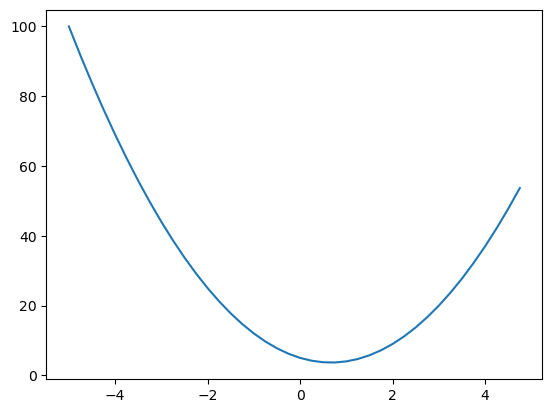

In [6]:
plt.plot(xs, ys)

In [7]:
def dx_df(x):
    return 6*x - 4

In [8]:
dys = dx_df(xs)
dys

array([-34. , -32.5, -31. , -29.5, -28. , -26.5, -25. , -23.5, -22. ,
       -20.5, -19. , -17.5, -16. , -14.5, -13. , -11.5, -10. ,  -8.5,
        -7. ,  -5.5,  -4. ,  -2.5,  -1. ,   0.5,   2. ,   3.5,   5. ,
         6.5,   8. ,   9.5,  11. ,  12.5,  14. ,  15.5,  17. ,  18.5,
        20. ,  21.5,  23. ,  24.5])

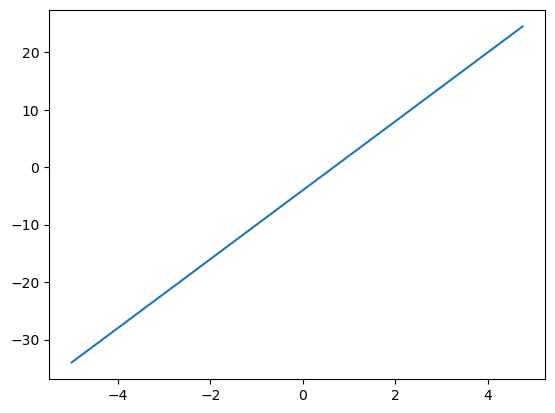

In [9]:
plt.plot(xs, dys)

$$L = {lim}_{h \rightarrow 0}\frac{f(x+h) - f(x)}{h}$$

In [10]:
h = 0.000001
x = -3.0
(f(x+h) - f(x)) / h

-21.999997002808414

In [11]:
# lets get more complex

h = 0.00001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
# a += h 
# b += h
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1) / h)

d1 4.0
d2 4.00001
slope 0.9999999999621422


In [37]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out


In [43]:
a = Value(2.0,  label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L
# (a.__mul__(b)).__add__(c)

Value(data=-8.0)

In [44]:
d._prev

{Value(data=-6.0), Value(data=10.0)}

In [45]:
d._op

'+'

In [46]:
from graphviz import Digraph

def trace(root):
    # build a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f}" % (n.label, n.data, ), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid+n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

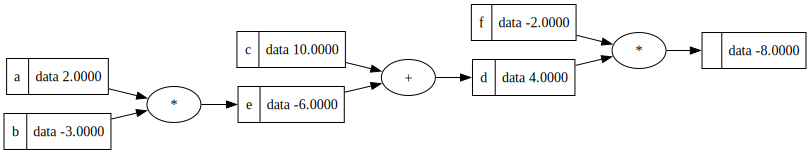

In [47]:
draw_dot(L)